In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('fifa_players.csv')

In [3]:
df['id'] = df.index
df.set_index('id', inplace=True)

In [4]:
df.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
id,,,,,,,,,,,,,,,,,,,,,
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


In [5]:
df.drop(['name', 'full_name', 'birth_date' , 'national_team' , 'national_rating' , 'national_team_position','national_jersey_number'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17954 entries, 0 to 17953
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            17954 non-null  int64  
 1   height_cm                      17954 non-null  float64
 2   weight_kgs                     17954 non-null  float64
 3   positions                      17954 non-null  object 
 4   nationality                    17954 non-null  object 
 5   overall_rating                 17954 non-null  int64  
 6   potential                      17954 non-null  int64  
 7   value_euro                     17699 non-null  float64
 8   wage_euro                      17708 non-null  float64
 9   preferred_foot                 17954 non-null  object 
 10  international_reputation(1-5)  17954 non-null  int64  
 11  weak_foot(1-5)                 17954 non-null  int64  
 12  skill_moves(1-5)               17954 non-null  int6

# Histogram

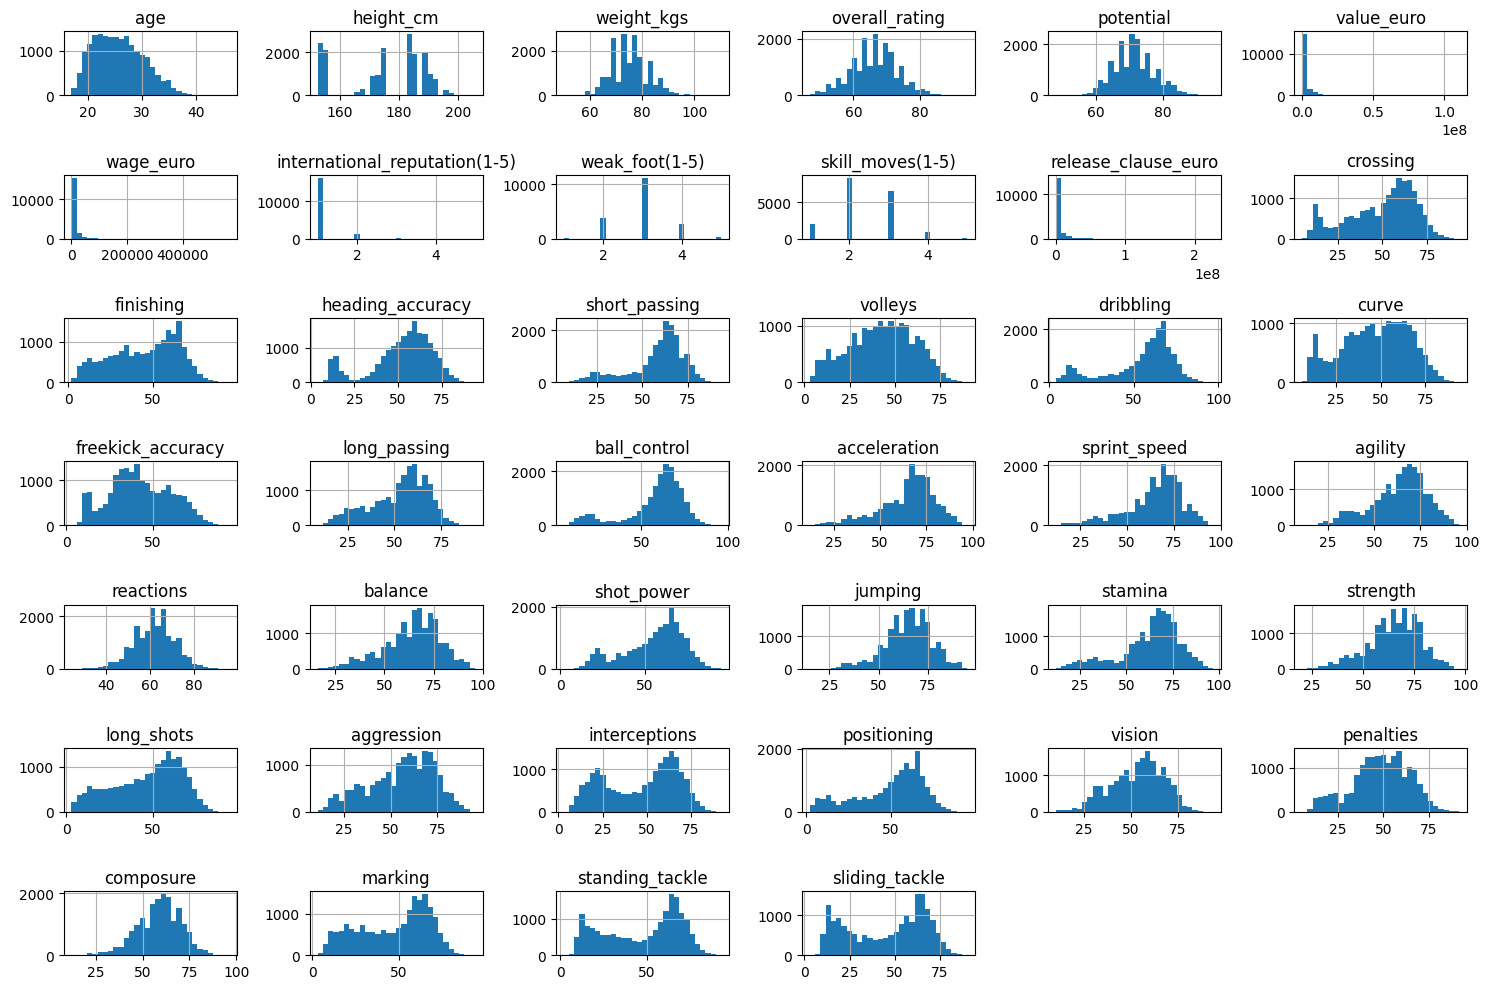

In [7]:
df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

# Handle missing values

## Remove missing values

In [8]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

value_euro              255
wage_euro               246
release_clause_euro    1837
dtype: int64


In [9]:
missing_cols = missing_values.index.tolist()
missing_cols

['value_euro', 'wage_euro', 'release_clause_euro']

In [10]:
df = df.dropna()
df.shape

(16117, 44)

# Handle 'String' attributes

In [11]:
object_cols = df.select_dtypes(include='object').columns

object_cols

Index(['positions', 'nationality', 'preferred_foot', 'body_type'], dtype='object')

## preferred_foot

In [12]:
df['preferred_foot'].value_counts()

preferred_foot
Right    12409
Left      3708
Name: count, dtype: int64

## body_type

In [13]:
df['body_type'].value_counts()

body_type
Normal                 9373
Lean                   5757
Stocky                  980
Messi                     1
Courtois                  1
PLAYER_BODY_TYPE_25       1
Akinfenwa                 1
Shaqiri                   1
Neymar                    1
C. Ronaldo                1
Name: count, dtype: int64

In [14]:
valid_body_types = ['Normal', 'Lean', 'Stocky']
df = df[df['body_type'].isin(valid_body_types)]

In [15]:
df['body_type'].value_counts()

body_type
Normal    9373
Lean      5757
Stocky     980
Name: count, dtype: int64

## nationality

In [16]:
df['nationality'].value_counts()

nationality
England                 1450
Germany                 1121
Spain                    959
France                   841
Brazil                   789
                        ... 
South Sudan                1
Andorra                    1
Hong Kong                  1
Indonesia                  1
United Arab Emirates       1
Name: count, Length: 157, dtype: int64

In [17]:
region_mapping = {
    "Western Europe": ["Germany", "France", "Italy", "Spain", "Portugal", "England", "Netherlands", "Belgium", "Switzerland"],
    "Eastern and Northern Europe": ["Russia", "Ukraine", "Poland", "Sweden", "Norway", "Denmark", "Finland"],
    "Southern Europe and Balkans": ["Greece", "Croatia", "Serbia", "Turkey", "Romania"],
    "North Africa and Middle East": ["Egypt", "Tunisia", "Morocco", "Iran", "Saudi Arabia"],
    "Sub-Saharan Africa": ["Nigeria", "Ghana", "Senegal", "Ivory Coast", "Cameroon"],
    "South America": ["Brazil", "Argentina", "Chile", "Colombia", "Uruguay"],
    "Central America and Caribbean": ["Mexico", "Costa Rica", "Jamaica", "Honduras"],
    "North America": ["United States", "Canada"],
    "East Asia": ["Japan", "South Korea", "China", "North Korea"],
    "Southeast Asia": ["Vietnam", "Thailand", "Indonesia", "Malaysia", "Philippines"],
    "South Asia": ["India", "Pakistan", "Bangladesh", "Nepal"],
    "Oceania": ["Australia", "New Zealand", "Fiji"]
}

country_to_region = {country: region for region, countries in region_mapping.items() for country in countries}

df['region'] = df['nationality'].map(country_to_region).fillna('Other')

In [18]:
df['region'].value_counts()

region
Western Europe                   5992
Other                            3028
South America                    2589
Eastern and Northern Europe      1509
Southern Europe and Balkans       620
Sub-Saharan Africa                472
East Asia                         447
North Africa and Middle East      422
Central America and Caribbean     385
North America                     383
Oceania                           255
Southeast Asia                      8
Name: count, dtype: int64

In [19]:
df.drop('nationality', axis=1, inplace=True)

In [20]:
df.head()

,age,height_cm,weight_kgs,positions,overall_rating,potential,value_euro,wage_euro,preferred_foot,international_reputation(1-5),...,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,region
id,,,,,,,,,,,,,,,,,,,,,
1,27,154.94,76.2,"CAM,RM,CM",88,89,69500000.0,205000.0,Right,3,...,46,56,84,91,67,88,59,57,22,Eastern and Northern Europe
2,25,190.50,83.9,"CM,CAM",88,91,73000000.0,255000.0,Right,4,...,78,64,82,88,82,87,63,67,67,Western Europe
3,27,162.56,59.0,"LW,ST",88,88,62000000.0,165000.0,Right,3,...,34,26,83,87,61,83,51,24,22,Western Europe
4,27,187.96,88.9,CB,88,91,60000000.0,135000.0,Right,3,...,87,88,24,49,33,80,91,88,87,Sub-Saharan Africa
5,27,193.04,92.1,CB,88,90,59500000.0,215000.0,Right,3,...,82,88,41,60,62,87,90,89,84,Western Europe


## positions

In [21]:
df['positions'].value_counts()

positions
CB              2045
GK              1936
ST              1519
CM               675
CDM,CM           633
                ... 
LM,CM,RM,RB        1
CM,LB,RM           1
CDM,CM,CF          1
LB,LM,CB           1
CAM,CM,RW,RM       1
Name: count, Length: 840, dtype: int64

In [22]:
df['positions'] = df['positions'].str.split(',')
df['positions']


id
1        [CAM, RM, CM]
2            [CM, CAM]
3             [LW, ST]
4                 [CB]
5                 [CB]
             ...      
17949    [RM, CAM, CM]
17950             [LB]
17951             [GK]
17952         [ST, LM]
17953             [ST]
Name: positions, Length: 16110, dtype: object

In [23]:
attacker = ['ST', 'LW', 'RW',  'CF' ,'CAM', 'RM', 'LM']
midfielder = ['CM', 'CDM', 'CAM','RM','LM' ]
defender = ['CB', 'LB', 'RB', 'LWB', 'RWB']
goalkeeper = ['GK']

# Encoding

In [24]:
object_cols = df.select_dtypes(include='object').columns
object_cols

Index(['positions', 'preferred_foot', 'body_type', 'region'], dtype='object')

## preferred_foot

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
temp_encoded = le.fit_transform(df['preferred_foot'])

for original, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"{original} -> {encoded}")

df['preferred_foot'] = temp_encoded

Left -> 0
Right -> 1


## body_type

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
temp_encoded = le.fit_transform(df['body_type'])

for original, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"{original} -> {encoded}")

df['body_type'] = temp_encoded

Lean -> 0
Normal -> 1
Stocky -> 2


## region

In [27]:
temp_encoded = le.fit_transform(df['region'])

for original, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"{original} -> {encoded}")

df['region'] = temp_encoded


Central America and Caribbean -> 0
East Asia -> 1
Eastern and Northern Europe -> 2
North Africa and Middle East -> 3
North America -> 4
Oceania -> 5
Other -> 6
South America -> 7
Southeast Asia -> 8
Southern Europe and Balkans -> 9
Sub-Saharan Africa -> 10
Western Europe -> 11


In [28]:
df.head()

,age,height_cm,weight_kgs,positions,overall_rating,potential,value_euro,wage_euro,preferred_foot,international_reputation(1-5),...,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,region
id,,,,,,,,,,,,,,,,,,,,,
1,27,154.94,76.2,"[CAM, RM, CM]",88,89,69500000.0,205000.0,1,3,...,46,56,84,91,67,88,59,57,22,2
2,25,190.50,83.9,"[CM, CAM]",88,91,73000000.0,255000.0,1,4,...,78,64,82,88,82,87,63,67,67,11
3,27,162.56,59.0,"[LW, ST]",88,88,62000000.0,165000.0,1,3,...,34,26,83,87,61,83,51,24,22,11
4,27,187.96,88.9,[CB],88,91,60000000.0,135000.0,1,3,...,87,88,24,49,33,80,91,88,87,10
5,27,193.04,92.1,[CB],88,90,59500000.0,215000.0,1,3,...,82,88,41,60,62,87,90,89,84,11


## positions

In [29]:

df['position_attacker'] = 0
df['position_midfielder'] = 0
df['position_defender'] = 0
df['position_goalkeeper'] = 0

def increment_position_count(positions, idx):
    for pos in positions:
        if pos in attacker:
            df.at[idx, 'position_attacker'] += 1
        if pos in midfielder:
            df.at[idx, 'position_midfielder'] += 1
        if pos in defender:
            df.at[idx, 'position_defender'] += 1
        if pos in goalkeeper:
            df.at[idx, 'position_goalkeeper'] += 1
for idx, row in df.iterrows():
    increment_position_count(row['positions'], idx)
df.drop('positions', axis=1, inplace=True)



In [30]:
df.head()

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,preferred_foot,international_reputation(1-5),weak_foot(1-5),...,penalties,composure,marking,standing_tackle,sliding_tackle,region,position_attacker,position_midfielder,position_defender,position_goalkeeper
id,,,,,,,,,,,,,,,,,,,,,
1,27,154.94,76.2,88,89,69500000.0,205000.0,1,3,5,...,67,88,59,57,22,2,2,3,0,0
2,25,190.50,83.9,88,91,73000000.0,255000.0,1,4,4,...,82,87,63,67,67,11,1,2,0,0
3,27,162.56,59.0,88,88,62000000.0,165000.0,1,3,4,...,61,83,51,24,22,11,2,0,0,0
4,27,187.96,88.9,88,91,60000000.0,135000.0,1,3,3,...,33,80,91,88,87,10,0,0,1,0
5,27,193.04,92.1,88,90,59500000.0,215000.0,1,3,3,...,62,87,90,89,84,11,0,0,1,0


# Downscaling

In [31]:

features_to_scale = ['value_euro', 'wage_euro', 'release_clause_euro','height_cm']
for feature in features_to_scale:
    print(f"{feature} :")
    print(f'Max : {df[feature].max()}  , Min : {df[feature].min()}\n')

value_euro :
Max : 102000000.0  , Min : 10000.0

wage_euro :
Max : 455000.0  , Min : 1000.0

release_clause_euro :
Max : 196400000.0  , Min : 13000.0

height_cm :
Max : 205.74  , Min : 152.4



In [32]:
df['value_euro']/=10000
df['wage_euro']/=1000
df['release_clause_euro']/=10000
df['height_cm']/=100

In [33]:
df.head()

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,preferred_foot,international_reputation(1-5),weak_foot(1-5),...,penalties,composure,marking,standing_tackle,sliding_tackle,region,position_attacker,position_midfielder,position_defender,position_goalkeeper
id,,,,,,,,,,,,,,,,,,,,,
1,27,1.5494,76.2,88,89,6950.0,205.0,1,3,5,...,67,88,59,57,22,2,2,3,0,0
2,25,1.9050,83.9,88,91,7300.0,255.0,1,4,4,...,82,87,63,67,67,11,1,2,0,0
3,27,1.6256,59.0,88,88,6200.0,165.0,1,3,4,...,61,83,51,24,22,11,2,0,0,0
4,27,1.8796,88.9,88,91,6000.0,135.0,1,3,3,...,33,80,91,88,87,10,0,0,1,0
5,27,1.9304,92.1,88,90,5950.0,215.0,1,3,3,...,62,87,90,89,84,11,0,0,1,0


# Export new train.csv

In [34]:
df.to_csv('data.csv', index=False)